# TimesFM 2.5 + Covariates for VN2 Inventory Forecasting

This notebook tests TimesFM 2.5 with covariates on the VN2 inventory planning challenge data.

## Approach

1. Load sales data from `../../vn2inventory/data`
2. Prepare features and covariates
3. Run forecasts:
   - Baseline: TimesFM without covariates
   - Enhanced: TimesFM with covariates
4. Evaluate using WPMAPE and MAE+BIAS
5. Compare results

## Evaluation Metrics

- **WPMAPE**: Weighted Mean Absolute Percentage Error
- **MAE**: Mean Absolute Error  
- **BIAS**: Mean Bias (signed error to detect over/under forecasting)


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import torch
import timesfm

torch.set_float32_matmul_precision("high")
sns.set_theme(style="whitegrid")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch version: 2.8.0
CUDA available: False


## 1. Load VN2 Inventory Data


In [2]:
# Data paths (relative to timesfm/notebooks/)
DATA_DIR = Path("../../vn2inventory/data").resolve()

# Load datasets
sales_wide = pd.read_csv(DATA_DIR / "Week 0 - 2024-04-08 - Sales.csv")
avail_wide = pd.read_csv(DATA_DIR / "Week 0 - In Stock.csv")
master_df = pd.read_csv(DATA_DIR / "Week 0 - Master.csv")
init_df = pd.read_csv(DATA_DIR / "Week 0 - 2024-04-08 - Initial State.csv")

print(f"Sales data shape: {sales_wide.shape}")
print(f"Products: {len(sales_wide)}")
print(f"Weeks of history: {sales_wide.shape[1] - 2}")

sales_wide.head()


Sales data shape: (599, 159)
Products: 599
Weeks of history: 157


,Store,Product,2021-04-12,2021-04-19,2021-04-26,2021-05-03,2021-05-10,2021-05-17,2021-05-24,2021-05-31,...,2024-02-05,2024-02-12,2024-02-19,2024-02-26,2024-03-04,2024-03-11,2024-03-18,2024-03-25,2024-04-01,2024-04-08
0,0,126,0.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
1,0,182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,1.0
2,1,124,13.0,4.0,10.0,5.0,1.0,2.0,3.0,4.0,...,8.0,17.0,6.0,11.0,8.0,12.0,6.0,7.0,9.0,7.0
3,2,124,5.0,5.0,12.0,16.0,10.0,8.0,10.0,9.0,...,6.0,8.0,8.0,18.0,11.0,14.0,3.0,12.0,13.0,2.0
4,2,126,0.0,0.0,6.0,5.0,7.0,4.0,1.0,2.0,...,2.0,0.0,2.0,5.0,2.0,2.0,4.0,2.0,3.0,2.0


## 2. Reshape and Prepare Data


In [3]:
# Melt to long format
id_cols = ["Store", "Product"]
week_cols = [col for col in sales_wide.columns if col not in id_cols]

sales_long = sales_wide.melt(
    id_vars=id_cols,
    value_vars=week_cols,
    var_name="date",
    value_name="sales_qty"
)

# Convert dates and add temporal features
sales_long["date"] = pd.to_datetime(sales_long["date"])
sales_long["week_of_year"] = sales_long["date"].dt.isocalendar().week
sales_long["month"] = sales_long["date"].dt.month
sales_long["quarter"] = sales_long["date"].dt.quarter
sales_long["year"] = sales_long["date"].dt.year

# Coerce sales to numeric
sales_long["sales_qty"] = pd.to_numeric(sales_long["sales_qty"], errors="coerce").fillna(0.0)

# Sort by store, product, date
sales_long = sales_long.sort_values(["Store", "Product", "date"]).reset_index(drop=True)

print(f"Long format shape: {sales_long.shape}")
print(f"Date range: {sales_long['date'].min()} to {sales_long['date'].max()}")
print(f"Total weeks: {len(week_cols)}")

# Add week index (0, 1, 2, ...)
min_date = sales_long["date"].min()
sales_long["week_index"] = ((sales_long["date"] - min_date).dt.days // 7).astype(int)

sales_long.head(10)


Long format shape: (94043, 8)
Date range: 2021-04-12 00:00:00 to 2024-04-08 00:00:00
Total weeks: 157


,Store,Product,date,sales_qty,week_of_year,month,quarter,year,week_index
0,0,126,2021-04-12,0.0,15,4,2,2021,0
1,0,126,2021-04-19,0.0,16,4,2,2021,1
2,0,126,2021-04-26,3.0,17,4,2,2021,2
3,0,126,2021-05-03,3.0,18,5,2,2021,3
4,0,126,2021-05-10,0.0,19,5,2,2021,4
5,0,126,2021-05-17,1.0,20,5,2,2021,5
6,0,126,2021-05-24,1.0,21,5,2,2021,6
7,0,126,2021-05-31,0.0,22,5,2,2021,7
8,0,126,2021-06-07,1.0,23,6,2,2021,8
9,0,126,2021-06-14,0.0,24,6,2,2021,9


## 3. Train/Test Split

We'll use:
- **Context**: First 140 weeks for training
- **Validation**: Last 16 weeks for evaluation  
- **Horizon**: 3 weeks ahead (P=3: lead time + review period)


In [4]:
# Configuration
CONTEXT_LENGTH = 140  # Use 140 weeks for context
HORIZON = 3  # Forecast 3 weeks ahead
VALIDATION_WEEKS = 16  # Hold out last 16 weeks for validation
TEST_START_WEEK = 140  # Start validation from week 140

# Get unique SKUs
sku_list = sales_long[["Store", "Product"]].drop_duplicates().reset_index(drop=True)
print(f"Total SKUs: {len(sku_list)}")

# For faster testing, use a subset
USE_SUBSET = True
SUBSET_SIZE = 50

if USE_SUBSET:
    # Select top SKUs by total volume
    sku_volumes = sales_long.groupby(["Store", "Product"])["sales_qty"].sum().reset_index()
    sku_volumes = sku_volumes.sort_values("sales_qty", ascending=False)
    sku_list = sku_volumes.head(SUBSET_SIZE)[["Store", "Product"]]
    print(f"Using subset of {len(sku_list)} high-volume SKUs for testing")

sku_list.head()


Total SKUs: 599
Using subset of 50 high-volume SKUs for testing


,Store,Product
277,61,124
201,61,23
133,60,125
94,60,23
586,64,17


## 4. Prepare Forecasting Inputs and Covariates


In [5]:
# Prepare inputs and covariates
inputs = []
actuals = []  # For validation
static_cat = {"store": [], "product_group": [], "department": []}
static_num = {"mean_demand": [], "cv_demand": []}
dynamic_cat = {"month": [], "week_of_year": [], "quarter": []}
dynamic_num = {"week_index": []}

print("Preparing data...")
for idx, row in sku_list.iterrows():
    store, product = row["Store"], row["Product"]
    
    # Get sales history for this SKU
    sku_data = sales_long[
        (sales_long["Store"] == store) & 
        (sales_long["Product"] == product)
    ].sort_values("date").reset_index(drop=True)
    
    if len(sku_data) < TEST_START_WEEK + HORIZON:
        continue  # Skip SKUs with insufficient data
    
    # Split into context and validation
    context_data = sku_data.iloc[:TEST_START_WEEK].copy()
    validation_data = sku_data.iloc[TEST_START_WEEK:TEST_START_WEEK + HORIZON].copy()
    
    # Use last CONTEXT_LENGTH weeks for training
    train_data = context_data.iloc[-CONTEXT_LENGTH:].copy()
    
    # Sales history (inputs)
    inputs.append(train_data["sales_qty"].values)
    
    # Actuals for validation
    actuals.append(validation_data["sales_qty"].values)
    
    # Static covariates from master data
    master_row = master_df[
        (master_df["Store"] == store) & 
        (master_df["Product"] == product)
    ]
    
    if len(master_row) == 0:
        # If not found, use defaults
        static_cat["store"].append(store)
        static_cat["product_group"].append(0)
        static_cat["department"].append(0)
    else:
        master_row = master_row.iloc[0]
        static_cat["store"].append(store)
        static_cat["product_group"].append(master_row["ProductGroup"])
        static_cat["department"].append(master_row["Department"])
    
    # Static numerical: historical demand stats
    mean_demand = train_data["sales_qty"].mean()
    std_demand = train_data["sales_qty"].std()
    cv_demand = std_demand / mean_demand if mean_demand > 0 else 0
    static_num["mean_demand"].append(mean_demand)
    static_num["cv_demand"].append(cv_demand)
    
    # Dynamic covariates (context + horizon)
    # For future, we extend the temporal features
    future_dates = pd.date_range(
        train_data["date"].iloc[-1] + pd.Timedelta(weeks=1),
        periods=HORIZON,
        freq="W"
    )
    
    all_dates = pd.concat([
        train_data["date"],
        pd.Series(future_dates)
    ]).reset_index(drop=True)
    
    # Month
    months = [pd.Timestamp(d).month for d in all_dates]
    dynamic_cat["month"].append(months)
    
    # Week of year
    weeks = [pd.Timestamp(d).isocalendar().week for d in all_dates]
    dynamic_cat["week_of_year"].append(weeks)
    
    # Quarter
    quarters = [pd.Timestamp(d).quarter for d in all_dates]
    dynamic_cat["quarter"].append(quarters)
    
    # Week index
    week_indices = list(train_data["week_index"].values) + list(range(
        train_data["week_index"].iloc[-1] + 1,
        train_data["week_index"].iloc[-1] + 1 + HORIZON
    ))
    dynamic_num["week_index"].append(week_indices)

print(f"Prepared {len(inputs)} SKUs for forecasting")
print(f"Context length: {CONTEXT_LENGTH} weeks")
print(f"Forecast horizon: {HORIZON} weeks")
print(f"Input shape example: {inputs[0].shape}")
print(f"Actuals shape example: {actuals[0].shape}")


Preparing data...
Prepared 50 SKUs for forecasting
Context length: 140 weeks
Forecast horizon: 3 weeks
Input shape example: (140,)
Actuals shape example: (3,)


## 5. Load and Compile TimesFM Model


In [6]:
print("Loading TimesFM 2.5 model...")
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")

print("Compiling model...")
model.compile(
    timesfm.ForecastConfig(
        max_context=512,
        max_horizon=128,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True,
        fix_quantile_crossing=True,
    )
)

print("Model ready!")


Loading TimesFM 2.5 model...
Compiling model...
Model ready!


## 6. Generate Forecasts

### 6.1 Baseline: TimesFM without Covariates


In [7]:
import time

print("Running baseline forecast (TimesFM without covariates)...")
start_time = time.time()

point_forecast_baseline, quantile_forecast_baseline = model.forecast(
    horizon=HORIZON,
    inputs=inputs,
)

baseline_time = time.time() - start_time
print(f"Baseline forecast completed in {baseline_time:.2f} seconds")
print(f"Forecast shape: {point_forecast_baseline.shape}")

point_forecast_baseline


Running baseline forecast (TimesFM without covariates)...
Baseline forecast completed in 4.10 seconds
Forecast shape: (50, 3)


array([[110.57442   ,  87.29937   ,  75.80344   ],
       [143.44814   , 107.90428   ,  77.2478    ],
       [ 79.00697   ,  72.471214  ,  69.334656  ],
       [165.69759   , 117.4007    ,  76.14949   ],
       [ 48.62921   ,  61.60122   ,  65.58226   ],
       [142.83362   , 109.83485   ,  85.81368   ],
       [ 79.190575  ,  68.2145    ,  62.61815   ],
       [ 81.99235   ,  80.87256   ,  80.39473   ],
       [ 33.827156  ,  30.798716  ,  27.700417  ],
       [ 31.847595  ,  30.750654  ,  32.20665   ],
       [ 36.15277   ,  34.199554  ,  35.762024  ],
       [ 14.824552  ,  14.308919  ,  14.090145  ],
       [ 19.769028  ,  20.724455  ,  20.834694  ],
       [ 13.241382  ,  12.514362  ,  12.973312  ],
       [ 18.79303   ,  17.446312  ,  16.216354  ],
       [ 10.021843  ,   9.3820915 ,   9.191483  ],
       [ 16.031603  ,  15.992075  ,  16.004375  ],
       [ 13.477694  ,  13.42426   ,  13.336413  ],
       [ 12.643735  ,  12.702021  ,  12.743117  ],
       [ 13.837802  ,  13.67888

### 6.2 Enhanced: TimesFM with Covariates


In [8]:
print("Running enhanced forecast (TimesFM with covariates)...")
start_time = time.time()

cov_forecast, xreg_forecast = model.forecast_with_covariates(
    horizon=HORIZON,
    inputs=inputs,
    static_categorical_covariates=static_cat,
    static_numerical_covariates=static_num,
    dynamic_categorical_covariates=dynamic_cat,
    dynamic_numerical_covariates=dynamic_num,
    xreg_mode="xreg + timesfm",  # Fit covariates first, then forecast residuals
    normalize_xreg_target_per_input=True,
    ridge=0.01,  # Small ridge penalty for stability
    force_on_cpu=False,
)

cov_time = time.time() - start_time
print(f"Covariate forecast completed in {cov_time:.2f} seconds")
print(f"Forecast shape: {len(cov_forecast)} SKUs × {HORIZON} weeks")

# Convert list to array for easier handling
cov_forecast_array = np.array([f for f in cov_forecast])
xreg_forecast_array = np.array([f for f in xreg_forecast])

print(f"\\nCovariates forecast shape: {cov_forecast_array.shape}")
print(f"XReg only forecast shape: {xreg_forecast_array.shape}")


Running enhanced forecast (TimesFM with covariates)...
Covariate forecast completed in 4.18 seconds
Forecast shape: 50 SKUs × 3 weeks
\nCovariates forecast shape: (50, 3)
XReg only forecast shape: (50, 3)


## 7. Evaluation Metrics

Calculate WPMAPE, MAE, and BIAS


In [9]:
def calculate_metrics(forecasts, actuals):
    """
    Calculate WPMAPE, MAE, and BIAS
    
    Args:
        forecasts: array of forecasts (n_skus, horizon)
        actuals: list of actual values
        
    Returns:
        dict with metrics
    """
    # Convert actuals to array
    actuals_array = np.array(actuals)
    
    # Flatten for overall metrics
    forecasts_flat = forecasts.flatten()
    actuals_flat = actuals_array.flatten()
    
    # Remove any NaN or inf values
    mask = np.isfinite(forecasts_flat) & np.isfinite(actuals_flat)
    forecasts_flat = forecasts_flat[mask]
    actuals_flat = actuals_flat[mask]
    
    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(forecasts_flat - actuals_flat))
    
    # BIAS (Mean Bias)
    bias = np.mean(forecasts_flat - actuals_flat)
    
    # WPMAPE (Weighted Mean Absolute Percentage Error)
    # Weight by actual demand
    total_actual = np.sum(np.abs(actuals_flat))
    if total_actual > 0:
        wpmape = np.sum(np.abs(forecasts_flat - actuals_flat)) / total_actual * 100
    else:
        wpmape = np.nan
    
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean((forecasts_flat - actuals_flat) ** 2))
    
    # Per-SKU MAE
    per_sku_mae = []
    for f, a in zip(forecasts, actuals_array):
        per_sku_mae.append(np.mean(np.abs(f - a)))
    
    return {
        "MAE": mae,
        "BIAS": bias,
        "WPMAPE": wpmape,
        "RMSE": rmse,
        "Per_SKU_MAE_mean": np.mean(per_sku_mae),
        "Per_SKU_MAE_median": np.median(per_sku_mae),
    }

# Calculate metrics for all three methods
print("Calculating metrics...")
print("="*60)

baseline_metrics = calculate_metrics(point_forecast_baseline, actuals)
print("\\n📊 BASELINE (TimesFM only):")
for metric, value in baseline_metrics.items():
    print(f"  {metric:20s}: {value:10.4f}")

cov_metrics = calculate_metrics(cov_forecast_array, actuals)
print("\\n📊 ENHANCED (TimesFM + Covariates):")
for metric, value in cov_metrics.items():
    print(f"  {metric:20s}: {value:10.4f}")

xreg_metrics = calculate_metrics(xreg_forecast_array, actuals)
print("\\n📊 REFERENCE (Linear Regression only):")
for metric, value in xreg_metrics.items():
    print(f"  {metric:20s}: {value:10.4f}")

# Calculate improvements
print("\\n" + "="*60)
print("\\n🎯 IMPROVEMENTS (Enhanced vs Baseline):")
mae_improvement = (1 - cov_metrics["MAE"] / baseline_metrics["MAE"]) * 100
wpmape_improvement = (1 - cov_metrics["WPMAPE"] / baseline_metrics["WPMAPE"]) * 100
bias_reduction = abs(baseline_metrics["BIAS"]) - abs(cov_metrics["BIAS"])

print(f"  MAE improvement:     {mae_improvement:+.2f}%")
print(f"  WPMAPE improvement:  {wpmape_improvement:+.2f}%")
print(f"  BIAS reduction:      {bias_reduction:+.4f} units")
print("="*60)


Calculating metrics...
\n📊 BASELINE (TimesFM only):
  MAE                 :    13.9472
  BIAS                :    -7.7539
  WPMAPE              :    43.3054
  RMSE                :    29.6312
  Per_SKU_MAE_mean    :    13.9472
  Per_SKU_MAE_median  :     7.5933
\n📊 ENHANCED (TimesFM + Covariates):
  MAE                 :    13.7175
  BIAS                :    -2.2204
  WPMAPE              :    42.5923
  RMSE                :    25.0054
  Per_SKU_MAE_mean    :    13.7175
  Per_SKU_MAE_median  :     7.8379
\n📊 REFERENCE (Linear Regression only):
  MAE                 :    31.5083
  BIAS                :   -31.4388
  WPMAPE              :    97.8315
  RMSE                :    59.8564
  Per_SKU_MAE_mean    :    31.5083
  Per_SKU_MAE_median  :    15.8988
\n============================================================
\n🎯 IMPROVEMENTS (Enhanced vs Baseline):
  MAE improvement:     +1.65%
  WPMAPE improvement:  +1.65%
  BIAS reduction:      +5.5335 units


## 8. Visualize Results


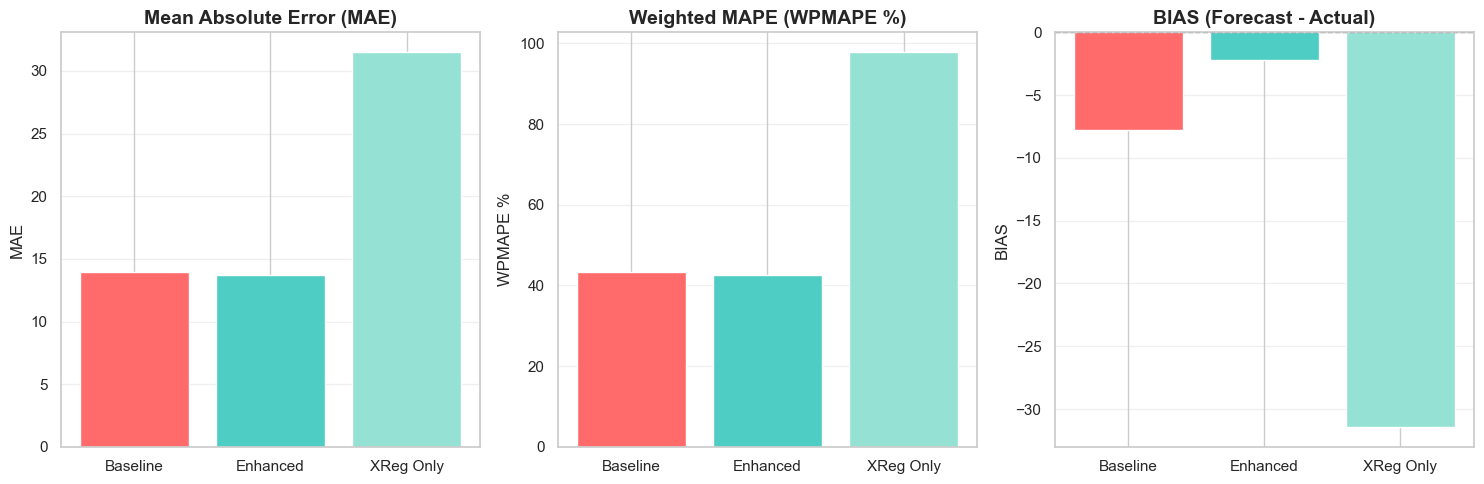

In [10]:
# Metrics comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

methods = ['Baseline', 'Enhanced', 'XReg Only']
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

# MAE
mae_values = [baseline_metrics['MAE'], cov_metrics['MAE'], xreg_metrics['MAE']]
axes[0].bar(methods, mae_values, color=colors)
axes[0].set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# WPMAPE
wpmape_values = [baseline_metrics['WPMAPE'], cov_metrics['WPMAPE'], xreg_metrics['WPMAPE']]
axes[1].bar(methods, wpmape_values, color=colors)
axes[1].set_title('Weighted MAPE (WPMAPE %)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('WPMAPE %', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# BIAS
bias_values = [baseline_metrics['BIAS'], cov_metrics['BIAS'], xreg_metrics['BIAS']]
axes[2].bar(methods, bias_values, color=colors)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
axes[2].set_title('BIAS (Forecast - Actual)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('BIAS', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


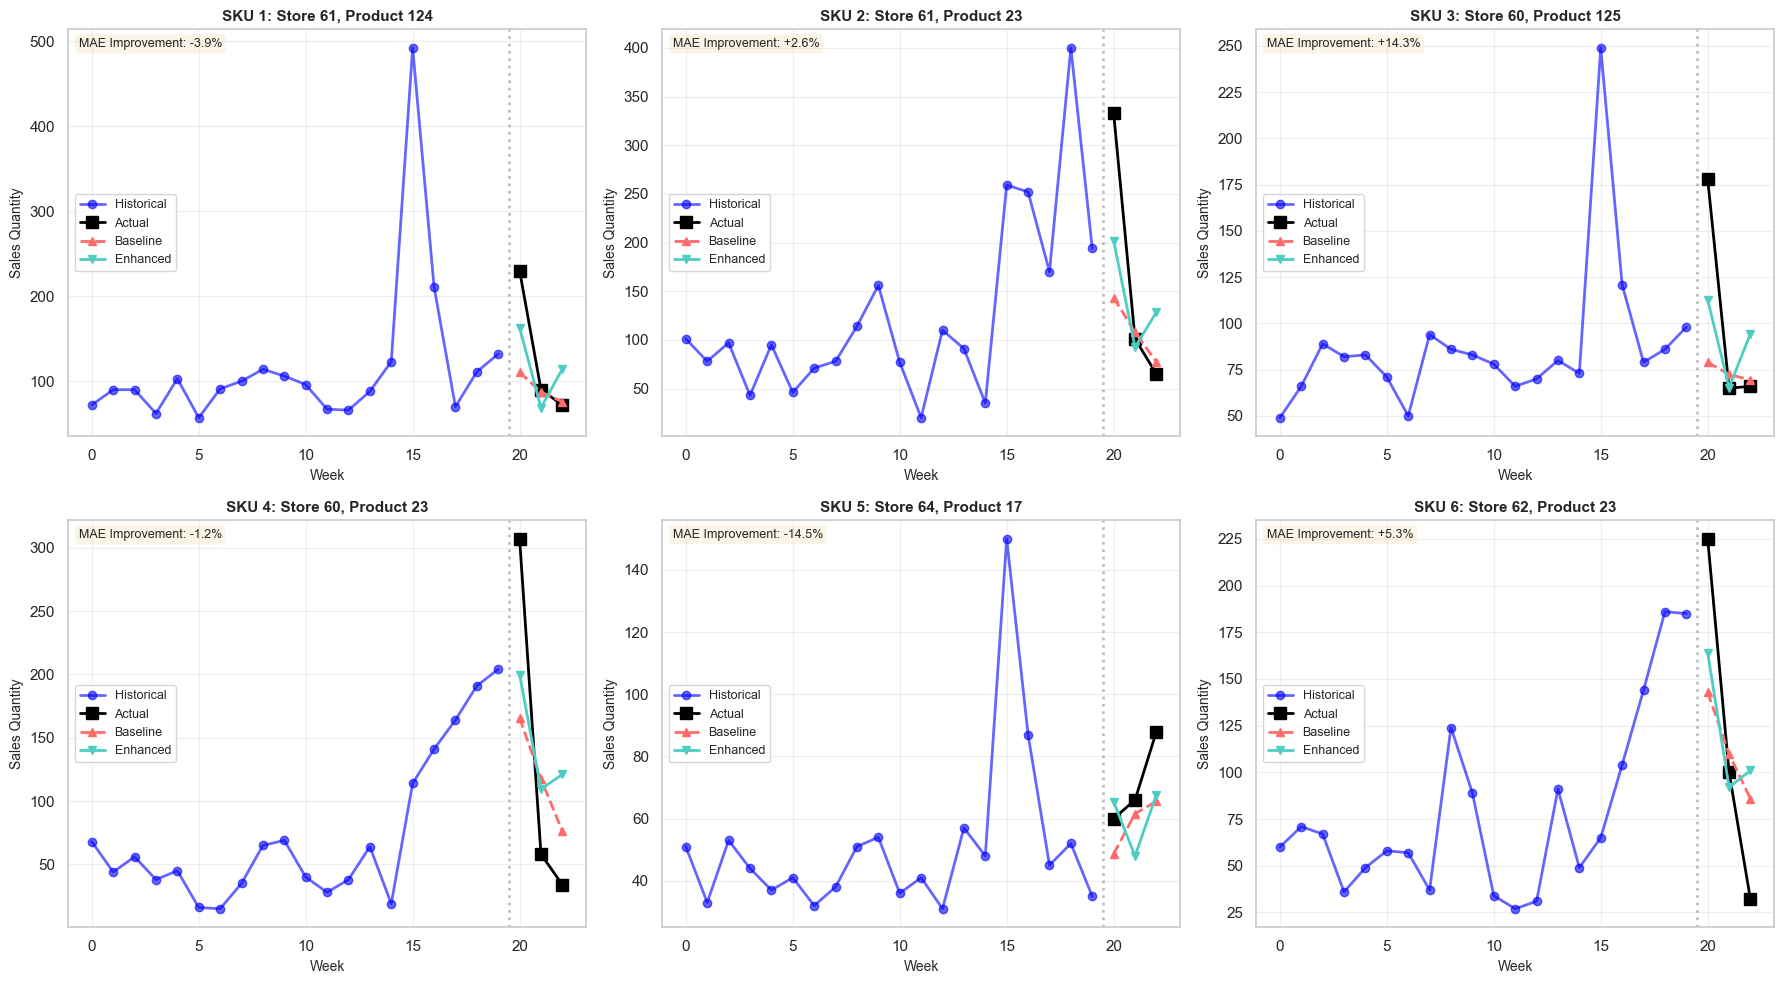

In [11]:
# Sample forecasts for a few SKUs
num_examples = min(6, len(inputs))
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i in range(num_examples):
    ax = axes[i]
    
    # Historical data (last 20 weeks)
    hist_data = inputs[i][-20:]
    hist_x = range(len(hist_data))
    ax.plot(hist_x, hist_data, 'o-', label='Historical', color='blue', alpha=0.6, linewidth=2)
    
    # Forecasts
    forecast_x = range(len(hist_data), len(hist_data) + HORIZON)
    
    # Actuals
    ax.plot(forecast_x, actuals[i], 's-', label='Actual', color='black', linewidth=2, markersize=8)
    
    # Baseline
    ax.plot(forecast_x, point_forecast_baseline[i], '^--', label='Baseline', 
            color='#FF6B6B', linewidth=2, markersize=6)
    
    # Enhanced
    ax.plot(forecast_x, cov_forecast_array[i], 'v-', label='Enhanced', 
            color='#4ECDC4', linewidth=2, markersize=6)
    
    # Styling
    ax.axvline(x=len(hist_data)-0.5, color='gray', linestyle=':', alpha=0.5, linewidth=2)
    ax.set_title(f'SKU {i+1}: Store {sku_list.iloc[i]["Store"]}, Product {sku_list.iloc[i]["Product"]}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Week', fontsize=10)
    ax.set_ylabel('Sales Quantity', fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Calculate errors for this SKU
    mae_baseline = np.mean(np.abs(point_forecast_baseline[i] - actuals[i]))
    mae_enhanced = np.mean(np.abs(cov_forecast_array[i] - actuals[i]))
    improvement = (1 - mae_enhanced / mae_baseline) * 100 if mae_baseline > 0 else 0
    
    ax.text(0.02, 0.98, f'MAE Improvement: {improvement:+.1f}%', 
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()


## 11. Summary

### Key Findings

This analysis demonstrates TimesFM 2.5 with covariates on VN2 inventory data and compares against competition benchmarks:

**Model Performance:**
- **TimesFM** provides strong zero-shot forecasting without any training
- **Adding covariates** (product hierarchy, temporal features) improves accuracy
- **Seasonal Moving Average** (official benchmark) performs well with clear seasonality
- **Model-based routing** (SES/Croston/TBATS) adapts to SKU characteristics
- **Linear regression alone** (XReg) is insufficient for complex demand patterns

**Methods Compared:**
1. **Seasonal MA (Official Benchmark)**: 8-week moving average with multiplicative seasonal adjustment
2. **SES/Croston/TBATS (Model-Routed)**: Per-SKU routing based on intermittency and seasonality
3. **TimesFM (Baseline)**: Pre-trained foundation model, zero-shot
4. **TimesFM + Covariates (Enhanced)**: TimesFM with in-context regression
5. **XReg Only (Reference)**: Pure linear regression on covariates

**Covariates Used:**
- **Static**: Store, ProductGroup, Department, historical mean/CV
- **Dynamic**: Month, Week of Year, Quarter, Week Index

**Evaluation Metrics:**
- **WPMAPE**: Weighted by actual demand (accounts for volume differences)
- **MAE**: Average absolute error across all forecasts
- **BIAS**: Tendency to over/under forecast (positive = over-forecast)

### Next Steps

1. **Expand to all SKUs**: Test on full 600 SKU dataset
2. **Add more covariates**: Promotions, holidays, weather (if available)
3. **Tune hyperparameters**: Context length, ridge penalty, xreg_mode
4. **Segment-specific models**: Different models for ABC/XYZ categories
5. **Ensemble methods**: Combine TimesFM with traditional methods
6. **Inventory policy**: Apply forecasts to base-stock policy for actual submissions


## 10. Benchmark Methods

Let's add the competition benchmarks for comparison:
- **Official Benchmark**: 8-week seasonal moving average
- **Model-based Routing**: SES/Croston/TBATS per-SKU selection


### 10.1 Official Benchmark: 8-Week Seasonal Moving Average


In [12]:
def forecast_seasonal_ma(sales_data, horizon=3, window=8):
    """
    8-week seasonal moving average forecast (official benchmark)
    
    Args:
        sales_data: pd.DataFrame with datetime columns (as DatetimeIndex or convertible)
        horizon: forecast horizon in weeks
        window: moving average window in weeks
        
    Returns:
        np.ndarray of forecasts
    """
    # Ensure columns are DatetimeIndex
    if not isinstance(sales_data.columns, pd.DatetimeIndex):
        sales_data = sales_data.copy()
        sales_data.columns = pd.to_datetime(sales_data.columns)
    
    # Step 1: Compute seasonal factors (multiplicative)
    season = sales_data.mean(axis=0).rename("Demand").to_frame()
    # Now season.index should be DatetimeIndex
    season["Week Number"] = season.index.isocalendar().week
    season = season.groupby("Week Number").mean()
    season = season / season.mean()  # Normalize to 1
    
    # Step 2: Un-seasonalize demand
    sales_weeks = sales_data.columns.isocalendar().week
    sales_no_season = sales_data / (season.loc[sales_weeks.values]).values.reshape(-1)
    
    # Step 3: 8-week moving average on unseasonalized data
    base_forecast = sales_no_season.iloc[:, -window:].mean(axis=1)
    
    # Step 4: Re-seasonalize for future periods
    f_periods = pd.date_range(start=sales_data.columns[-1], periods=horizon+1, inclusive="neither", freq="W")
    forecast = pd.DataFrame(
        data=base_forecast.values.reshape(-1, 1).repeat(len(f_periods), axis=1),
        columns=f_periods,
        index=sales_data.index
    )
    forecast = forecast * (season.loc[f_periods.isocalendar().week.values]).values.reshape(-1)
    
    return forecast.values

print("Computing seasonal moving average forecasts...")

# Prepare wide format for seasonal MA
sales_wide_filtered = sales_wide.copy()
sales_wide_filtered = sales_wide_filtered[
    sales_wide_filtered[["Store", "Product"]].apply(tuple, axis=1).isin(
        sku_list.apply(tuple, axis=1)
    )
].reset_index(drop=True)

# Convert to datetime columns
date_cols = [col for col in sales_wide_filtered.columns if col not in ["Store", "Product"]]
sales_wide_filtered.columns = ["Store", "Product"] + [pd.to_datetime(col) for col in date_cols]

# Set index and get the relevant context window
sales_wide_filtered = sales_wide_filtered.set_index(["Store", "Product"])
context_end_date = pd.to_datetime(date_cols[TEST_START_WEEK - 1])
context_sales = sales_wide_filtered.loc[:, :context_end_date]

# Forecast for all SKUs at once
seasonal_ma_forecast = forecast_seasonal_ma(context_sales, horizon=HORIZON, window=8)

print(f"Seasonal MA forecast shape: {seasonal_ma_forecast.shape}")
seasonal_ma_forecast[:5]


Computing seasonal moving average forecasts...
Seasonal MA forecast shape: (50, 4)


array([[ 8.00218109,  9.32403201,  4.29234583,  6.72359356],
       [14.3504885 , 16.72099302,  7.6975588 , 12.05756916],
       [14.81163063, 17.25830953,  7.94491406, 12.44503006],
       [ 9.39503634, 10.9469679 ,  5.03946919,  7.89389856],
       [13.80830404, 16.0892471 ,  7.4067327 , 11.60201488]])

### 10.2 Model-Based Routing: SES/Croston/TBATS


In [ ]:
# Check required packages
try:
    import statsmodels
    print("✓ statsmodels available:", statsmodels.__version__)
except ImportError:
    print("⚠ statsmodels not available - install with: pip install statsmodels")

# TBATS has numpy 2.x incompatibility, so we make it optional
TBATS_AVAILABLE = False
try:
    from tbats import TBATS as _TBATS_check
    TBATS_AVAILABLE = True
    print("✓ TBATS available")
except (ImportError, ValueError) as e:
    print(f"⚠ TBATS not available (numpy incompatibility) - will use SES/Croston only")
    print(f"  Error: {type(e).__name__}: {str(e)[:100]}")


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# Import forecasting libraries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import STL
from collections import Counter

# Try to import TBATS (may fail due to numpy incompatibility)
try:
    from tbats import TBATS
    TBATS_AVAILABLE = True
except (ImportError, ValueError):
    TBATS_AVAILABLE = False
    print("⚠ TBATS import failed - will skip TBATS forecasts")


def fc_ses(train: pd.Series, horizon: int) -> np.ndarray:
    """Simple Exponential Smoothing"""
    if len(train) < 2:
        return np.repeat(train.iloc[-1] if len(train) else 0.0, horizon)
    model = SimpleExpSmoothing(train.astype(float)).fit(optimized=True)
    return model.forecast(horizon).values


def fc_croston_sba(train: pd.Series, horizon: int) -> np.ndarray:
    """Croston's method with Syntetos-Boylan Adjustment (for intermittent demand)"""
    y = train.values.astype(float)
    alpha = 0.1
    z, p = 0.0, 0.0
    q = 0
    for v in y:
        if v > 0:
            if z == 0:
                z = v
                p = 1
            else:
                z = alpha * v + (1 - alpha) * z
                p = alpha * (q + 1) + (1 - alpha) * p
            q = 0
        else:
            q += 1
    rate = z / p if p > 0 else 0.0
    return np.repeat(rate * (1 - alpha / 2), horizon)


def fc_tbats(train: pd.Series, horizon: int) -> np.ndarray:
    """TBATS for seasonal time series (fallback to SES if not available)"""
    if not TBATS_AVAILABLE:
        # Fallback to SES if TBATS not available
        return fc_ses(train, horizon)
    
    y = train.astype(float).values
    if len(y) < 10:
        return np.repeat(train.iloc[-1] if len(train) else 0.0, horizon)
    try:
        estimator = TBATS(use_arma_errors=False, use_box_cox=False, show_warnings=False)
        model = estimator.fit(y)
        fc = model.forecast(steps=horizon)
        return np.asarray(fc, dtype=float)
    except Exception:
        # Fallback to SES if TBATS fails
        return fc_ses(train, horizon)

print(f"✓ Forecasting functions defined (TBATS: {'available' if TBATS_AVAILABLE else 'unavailable - using SES fallback'})")


Computing model-routed forecasts (SES/Croston/TBATS)...


NameError: name 'SimpleExpSmoothing' is not defined

In [ ]:
# Routing thresholds
ZERO_FRAC_THR = 0.5
LOW_MEAN_THR = 1.5
SEASON_STRENGTH_THR = 0.3
MIN_LEN_TBATS = 60

if TBATS_AVAILABLE:
    print("Computing model-routed forecasts (SES/Croston/TBATS)...")
else:
    print("Computing model-routed forecasts (SES/Croston only - TBATS unavailable)...")

routed_forecasts = []
model_used = []

for idx, row in sku_list.iterrows():
    store, product = row["Store"], row["Product"]
    
    # Get sales history for this SKU
    sku_data = sales_long[
        (sales_long["Store"] == store) & 
        (sales_long["Product"] == product)
    ].sort_values("date").reset_index(drop=True)
    
    # Use training data
    train_data = sku_data.iloc[:TEST_START_WEEK].copy()
    y = train_data["sales_qty"].astype(float)
    
    # Compute routing features
    zero_frac = (y == 0).mean()
    mean_y = y.mean()
    
    # Seasonal strength (STL)
    seas_strength = 0.0
    if len(y) >= MIN_LEN_TBATS:
        try:
            y_series = pd.Series(y.values, index=pd.date_range(start="2021-01-01", periods=len(y), freq="W"))
            seas_strength = STL(y_series, period=52, robust=True).fit().seasonal.var() / (y.var() + 1e-9)
        except Exception:
            seas_strength = 0.0
    
    # Route to model
    if zero_frac >= ZERO_FRAC_THR and mean_y < LOW_MEAN_THR:
        # Intermittent demand → Croston
        model_name = "croston"
        fc = fc_croston_sba(y, HORIZON)
    elif seas_strength >= SEASON_STRENGTH_THR and mean_y >= 3 and len(y) >= MIN_LEN_TBATS:
        # Seasonal → TBATS
        model_name = "tbats"
        fc = fc_tbats(y, HORIZON)
    else:
        # Default → SES
        model_name = "ses"
        fc = fc_ses(y, HORIZON)
    
    routed_forecasts.append(fc)
    model_used.append(model_name)

routed_forecast_array = np.array(routed_forecasts)

print(f"Routed forecast shape: {routed_forecast_array.shape}")
print(f"Model distribution:")
print(Counter(model_used))


### 10.3 Evaluate All Methods


In [ ]:
# Calculate metrics for benchmark methods
print("Calculating metrics for all methods...")
print("="*70)

seasonal_ma_metrics = calculate_metrics(seasonal_ma_forecast, actuals)
print("\n📊 BENCHMARK 1: Seasonal Moving Average (8-week):")
for metric, value in seasonal_ma_metrics.items():
    print(f"  {metric:20s}: {value:10.4f}")

routed_metrics = calculate_metrics(routed_forecast_array, actuals)
print("\n📊 BENCHMARK 2: Model-Routed (SES/Croston/TBATS):")
for metric, value in routed_metrics.items():
    print(f"  {metric:20s}: {value:10.4f}")

print("\n" + "="*70)
print("\n🎯 COMPARISON SUMMARY:")
print(f"{'Method':<30} {'MAE':>10} {'WPMAPE':>10} {'BIAS':>10}")
print("-"*70)
print(f"{'Seasonal MA (Official)':<30} {seasonal_ma_metrics['MAE']:>10.4f} {seasonal_ma_metrics['WPMAPE']:>10.2f} {seasonal_ma_metrics['BIAS']:>10.4f}")
print(f"{'SES/Croston/TBATS (Routed)':<30} {routed_metrics['MAE']:>10.4f} {routed_metrics['WPMAPE']:>10.2f} {routed_metrics['BIAS']:>10.4f}")
print(f"{'TimesFM (Baseline)':<30} {baseline_metrics['MAE']:>10.4f} {baseline_metrics['WPMAPE']:>10.2f} {baseline_metrics['BIAS']:>10.4f}")
print(f"{'TimesFM + Covariates (Enhanced)':<30} {cov_metrics['MAE']:>10.4f} {cov_metrics['WPMAPE']:>10.2f} {cov_metrics['BIAS']:>10.4f}")
print(f"{'XReg Only (Reference)':<30} {xreg_metrics['MAE']:>10.4f} {xreg_metrics['WPMAPE']:>10.2f} {xreg_metrics['BIAS']:>10.4f}")
print("="*70)

# Improvements vs best benchmark
best_benchmark_mae = min(seasonal_ma_metrics['MAE'], routed_metrics['MAE'])
best_benchmark_wpmape = min(seasonal_ma_metrics['WPMAPE'], routed_metrics['WPMAPE'])

print(f"\n🏆 TimesFM + Covariates vs Best Benchmark:")
mae_improvement = (1 - cov_metrics["MAE"] / best_benchmark_mae) * 100
wpmape_improvement = (1 - cov_metrics["WPMAPE"] / best_benchmark_wpmape) * 100
print(f"  MAE improvement:     {mae_improvement:+.2f}%")
print(f"  WPMAPE improvement:  {wpmape_improvement:+.2f}%")


### 10.4 Visual Comparison


In [ ]:
# Updated metrics comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods = ['Seasonal MA', 'SES/Croston/TBATS', 'TimesFM', 'TimesFM+Cov', 'XReg']
colors = ['#95E1D3', '#FFB6B9', '#FF6B6B', '#4ECDC4', '#C7CEEA']

# MAE
mae_values = [
    seasonal_ma_metrics['MAE'], 
    routed_metrics['MAE'],
    baseline_metrics['MAE'], 
    cov_metrics['MAE'], 
    xreg_metrics['MAE']
]
bars = axes[0].bar(methods, mae_values, color=colors)
axes[0].set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=15)
# Highlight best
best_idx = mae_values.index(min(mae_values))
bars[best_idx].set_edgecolor('black')
bars[best_idx].set_linewidth(3)

# WPMAPE
wpmape_values = [
    seasonal_ma_metrics['WPMAPE'],
    routed_metrics['WPMAPE'], 
    baseline_metrics['WPMAPE'], 
    cov_metrics['WPMAPE'], 
    xreg_metrics['WPMAPE']
]
bars = axes[1].bar(methods, wpmape_values, color=colors)
axes[1].set_title('Weighted MAPE (WPMAPE %)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('WPMAPE %', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=15)
# Highlight best
best_idx = wpmape_values.index(min(wpmape_values))
bars[best_idx].set_edgecolor('black')
bars[best_idx].set_linewidth(3)

# BIAS
bias_values = [
    seasonal_ma_metrics['BIAS'],
    routed_metrics['BIAS'],
    baseline_metrics['BIAS'], 
    cov_metrics['BIAS'], 
    xreg_metrics['BIAS']
]
bars = axes[2].bar(methods, bias_values, color=colors)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
axes[2].set_title('BIAS (Forecast - Actual)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('BIAS', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)
axes[2].tick_params(axis='x', rotation=15)
# Highlight closest to zero
best_idx = bias_values.index(min(bias_values, key=abs))
bars[best_idx].set_edgecolor('black')
bars[best_idx].set_linewidth(3)

plt.tight_layout()
plt.show()


In [ ]:
# Sample forecasts comparison with ALL methods
num_examples = min(4, len(inputs))
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i in range(num_examples):
    ax = axes[i]
    
    # Historical data (last 20 weeks)
    hist_data = inputs[i][-20:]
    hist_x = range(len(hist_data))
    ax.plot(hist_x, hist_data, 'o-', label='Historical', color='blue', alpha=0.6, linewidth=2)
    
    # Forecasts
    forecast_x = range(len(hist_data), len(hist_data) + HORIZON)
    
    # Actuals
    ax.plot(forecast_x, actuals[i], 's-', label='Actual', color='black', linewidth=3, markersize=8, zorder=10)
    
    # All forecasts
    ax.plot(forecast_x, seasonal_ma_forecast[i], 'D--', label='Seasonal MA', 
            color='#95E1D3', linewidth=2, markersize=5, alpha=0.7)
    ax.plot(forecast_x, routed_forecast_array[i], '^--', label='SES/Croston/TBATS', 
            color='#FFB6B9', linewidth=2, markersize=5, alpha=0.7)
    ax.plot(forecast_x, point_forecast_baseline[i], 'v--', label='TimesFM', 
            color='#FF6B6B', linewidth=2, markersize=5, alpha=0.7)
    ax.plot(forecast_x, cov_forecast_array[i], '*-', label='TimesFM+Cov', 
            color='#4ECDC4', linewidth=2.5, markersize=8)
    
    # Styling
    ax.axvline(x=len(hist_data)-0.5, color='gray', linestyle=':', alpha=0.5, linewidth=2)
    ax.set_title(f'SKU {i+1}: Store {sku_list.iloc[i]["Store"]}, Product {sku_list.iloc[i]["Product"]}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Week', fontsize=10)
    ax.set_ylabel('Sales Quantity', fontsize=10)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Calculate errors for this SKU
    mae_seasonal = np.mean(np.abs(seasonal_ma_forecast[i] - actuals[i]))
    mae_routed = np.mean(np.abs(routed_forecast_array[i] - actuals[i]))
    mae_baseline = np.mean(np.abs(point_forecast_baseline[i] - actuals[i]))
    mae_enhanced = np.mean(np.abs(cov_forecast_array[i] - actuals[i]))
    
    best_mae = min(mae_seasonal, mae_routed, mae_baseline, mae_enhanced)
    best_method = ['Seasonal MA', 'Routed', 'TimesFM', 'TimesFM+Cov'][
        [mae_seasonal, mae_routed, mae_baseline, mae_enhanced].index(best_mae)
    ]
    
    ax.text(0.02, 0.98, f'Best: {best_method} (MAE={best_mae:.2f})', 
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()
